### SICK dataset
We will use SICK dataset throughout the project (at least in the first two tasks). To get more information about the dataset you can refer to the original [paper](http://www.lrec-conf.org/proceedings/lrec2014/pdf/363_Paper.pdf) on the dataset. You can download the dataset using one of the following links:
- [dataset page 1](https://marcobaroni.org/composes/sick.html)
- [dataset page 2](https://huggingface.co/datasets/sick)    

The relevant columns for the project are `sentence_A`, `sentence_B`, `relatedness_score`, where `relatedness_score` is the label. <br><br>
**Hint: For each task make sure to decide whether the label should be normalized or not.**<br><br>

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import torch
from test import evaluate_test_set
import sts_data
from importlib import reload

## Part 1. Data pipeline 

In [31]:
reload(sts_data)
from sts_data import STSData

columns_mapping = {
        "sent1": "sentence_A",
        "sent2": "sentence_B",
        "label": "relatedness_score",
    }
dataset_name = "sick"
sick_data = STSData(
    dataset_name=dataset_name,
    columns_mapping=columns_mapping,
    normalize_labels=True,
    normalization_const=5.0,
)
batch_size = 64

sick_dataloaders = sick_data.get_data_loader(batch_size=batch_size)

INFO:root:loading and preprocessing data...
100%|██████████| 3/3 [00:00<00:00, 749.92it/s]
INFO:root:Four kids are doing backbends in the park
INFO:root:Four children are doing backbends in the park
c:\Users\laure\Documents\NNTI\nlp_project_nnti 2\nlp_project_nnti\task2\preprocess.py:48: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['train']['sentence_A'] = dataset['train']['sentence_A'].str.replace(self.punctuation_regex, '')
c:\Users\laure\Documents\NNTI\nlp_project_nnti 2\nlp_project_nnti\task2\preprocess.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['train']['sentence_B'] = dataset['train']['sentence_B'].str.replace(self.punctuation_regex, '')
c:\Users\laure\Documents\NNTI\nlp_project_nnti 2\nlp_project_nnti\task2\preprocess.py:50: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['test']['sentence_A'] = dat

Testing vocab. Index for kids is 67
Testing vocab. Index for sentence ['kids', 'playing', 'yard', 'standing', 'background'] is [67, 4, 147, 7, 144]
<unk>
<pad>
woman
Index(['id', 'sentence_A', 'sentence_B', 'label', 'relatedness_score',
       'entailment_AB', 'entailment_BA', 'sentence_A_original',
       'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset'],
      dtype='object')
max len a: 14, max_len b: 14, max_len 14
[231, 95, 8, 575, 371, 1, 1, 1, 1, 1, 1, 1, 1, 1]
max len a: 12, max_len b: 14, max_len 14
[5, 6, 11, 43, 15, 24, 1, 1, 1, 1, 1, 1, 1, 1]
max len a: 14, max_len b: 14, max_len 14
[1350, 13, 17, 167, 1290, 183, 1, 1, 1, 1, 1, 1, 1, 1]


## Part 2. Model Configuration & Hyperparameter Tuning (3 points)
Here we developed a genetic algorithm to find the best possible hyperparameter configuration, since there are quite a few to tune. A genetic algorithm tries to model evolution in nature. By keeping a list of models, chossing the best performing ones and using those to create a set of child models. These children models take their hyperparameters from the parent models at random. For every hyperparameter, there is also a chance of a genetic mutation happening at the crossing over step.

By always keeping the best performing models in the list, we will continually improve performance thorugh generations.
Downside: it takes a long time to train the models, new hyperparameters introduced

In [32]:
hyper_param_search=True

output_size = 128
hidden_size = 403
vocab_size = len(sick_data.vocab)
embedding_size = 300
embedding_weights = sick_data.vocab.vectors
lstm_layers = 4
learning_rate = 0.00048586475278877557
fc_hidden_size = 89
max_epochs = 200
bidirectional = True
dropout = 0.12354567224086944
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## self attention config
self_attention_config = {
    "hidden_size": 400,  ## refers to variable 'da' in the ICLR paper
    "output_size": 14,  ## refers to variable 'r' in the ICLR paper
    "penalty": 0.1965166853622733,  ## refers to penalty coefficient term in the ICLR paper
}

attention_encoder_config = {
    "n_layers": 4,  ## number of encoder layers
    "n_heads": 16,  ## heads in multi-head attention
    "expansion": 4, ## encoder feed forward embedding size expansion factor
    "vocab_max": 15 ## max sequence length
}
pad_index = sick_data.vocab.stoi['<pad>']

In [34]:
from train import train_model, genetic_hyperparam_search

if hyper_param_search:
    genetic_hyperparam_search(data_loader=sick_dataloaders,device=device, vocab_size=vocab_size, embedding_weights=embedding_weights,max_epochs=30, num_gens=20, pad_index = pad_index,
    config_dict={
            "device": device,
            "model_name": "siamese_lstm_attention",
            "self_attention_config": self_attention_config,
        })

INFO:root:Finding best hyperparameters using genetic algorithm
INFO:root:starting generation 0
INFO:root:Starting train for model with parameters hidden_size=400,lstm_layers=7,fc=256,dropout=0.2033385656582415,a_hs=400,a_os=45,p=0.37343931588389256, lr=0.001, e_layers=2, output_size=47
100%|██████████| 20/20 [01:29<00:00,  4.47s/it]
INFO:root:0.19693821340039142
INFO:root:Starting train for model with parameters hidden_size=256,lstm_layers=3,fc=256,dropout=0.33711710313367854,a_hs=400,a_os=40,p=0.805082416371886, lr=0.001, e_layers=1, output_size=172
100%|██████████| 20/20 [00:37<00:00,  1.89s/it]
INFO:root:0.5753048865300283
INFO:root:Starting train for model with parameters hidden_size=320,lstm_layers=3,fc=256,dropout=0.383931958112374,a_hs=128,a_os=30,p=0.6301990683569092, lr=0.001, e_layers=8, output_size=6
100%|██████████| 20/20 [01:38<00:00,  4.95s/it]
INFO:root:0.18955796001841974
INFO:root:Starting train for model with parameters hidden_size=512,lstm_layers=6,fc=400,dropout=0.2

## Part 3. Training 

In [33]:
## INFO:root:Starting train for model with parameters hidden_size=188,lstm_layers=7,fc=64,dropout=0.28921560924210954,a_hs=400,a_os=30,p=0.6823968789902922, lr=0.0005, e_layers=5, output_size=135
## INFO:root:model with score 0.7053653888671435 and parameters hidden_size=465,lstm_layers=4,fc=276,dropout=0.1829432884751247,a_hs=400,a_os=1,p=0.9478965476642063, lr=8e-05, e_layers=1, output_size=271
## Notes: with penalty, there is a steep drop off in acuracy after the first epoch -> clash of attentions?  unlearn fasttext advantage?
## best performance with penalty of 0.0 -> self attention block does not do much, attention evenly spread across vectors
## best model found by genetic algorithm also tries to minimize self-atttntion block impact and trust fasttext embeddings

batch_size = 64
output_size = 271
hidden_size = 465
vocab_size = len(sick_data.vocab)
embedding_size = 300
embedding_weights = sick_data.vocab.vectors
lstm_layers = 4
learning_rate = 8e-05
fc_hidden_size = 276
max_epochs = 50
bidirectional = True
dropout = 0.1829432884751247
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## self attention config
self_attention_config = {
    "hidden_size": 300,  ## refers to variable 'da' in the ICLR paper
    "output_size": 1,  ## refers to variable 'r' in the ICLR paper
    "penalty": 0.9478965476642063,  ## refers to penalty coefficient term in the ICLR paper
}

attention_encoder_config = {
    "n_layers": 1,  ## number of encoder layers
    "n_heads": 15,  ## heads in multi-head attention
    "expansion": 4, ## encoder feed forward embedding size expansion factor
    "vocab_max": 50 ## max sequence length
}

In [34]:
from siamese_lstm_attention import SiameseBiLSTMAttention
## init siamese lstm
siamese_lstm_attention = SiameseBiLSTMAttention(
    batch_size=batch_size,
    output_size=output_size,
    hidden_size=hidden_size,
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    embedding_weights=embedding_weights,
    lstm_layers=lstm_layers,
    self_attention_config=self_attention_config,
    attention_encoder_config=attention_encoder_config,
    fc_hidden_size=fc_hidden_size,
    device=device,
    bidirectional=bidirectional,
    pad_index=pad_index,
    dropout=dropout
)
## move model to device
siamese_lstm_attention.to(device)

SiameseBiLSTMAttention(
  (word_embeddings): Embedding(1965, 300)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (attention): MultiHeadSelfAttention(
          (Q): Linear(in_features=300, out_features=300, bias=False)
          (K): Linear(in_features=300, out_features=300, bias=False)
          (V): Linear(in_features=300, out_features=300, bias=False)
          (output_layer): Linear(in_features=300, out_features=300, bias=True)
        )
        (Dropout): Dropout(p=0.1829432884751247, inplace=False)
        (LayerNorm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (LayerNorm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (FeedForward): Sequential(
          (0): Linear(in_features=300, out_features=1200, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1200, out_features=300, bias=True)
        )
      )
    )
    (pos_embedding): Embedding(50, 300)
    (Dropout): Dropout(p=0.1829432884751247, 

In [35]:
from train import train_model
torch.cuda.empty_cache()
optimizer = torch.optim.Adam(params=siamese_lstm_attention.parameters(), lr=learning_rate)

best_model, train_losses, train_accs, val_losses, val_accs = train_model(
    model=siamese_lstm_attention,
    optimizer=optimizer,
    dataloader=sick_dataloaders,
    data=sick_data,
    max_epochs=max_epochs,
    config_dict={
        "device": device,
        "model_name": "siamese_lstm_attention",
        "self_attention_config": self_attention_config,
    },
)

  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Epoch: 0
INFO:root:new model saved
INFO:root:Train loss: 1.6563981771469116 - acc: 0.6890925974668513 -- Validation loss: 1.6436710357666016 - acc: 0.7086627744338527
  2%|▏         | 1/50 [00:03<02:50,  3.48s/it]INFO:root:Epoch: 1
INFO:root:Train loss: 0.3427577018737793 - acc: 0.1460442653398114 -- Validation loss: 0.08203839510679245 - acc: 0.5478910849175341
  4%|▍         | 2/50 [00:06<02:38,  3.31s/it]INFO:root:Epoch: 2
INFO:root:Train loss: 0.033368874341249466 - acc: 0.4786251294543521 -- Validation loss: 0.04131932556629181 - acc: 0.623930825827753
  6%|▌         | 3/50 [00:09<02:33,  3.27s/it]INFO:root:Epoch: 3
INFO:root:Train loss: 0.026172351092100143 - acc: 0.6265772059846114 -- Validation loss: 0.025764478370547295 - acc: 0.7065069178534583
  8%|▊         | 4/50 [00:13<02:29,  3.25s/it]INFO:root:Epoch: 4
INFO:root:new model saved
INFO:root:Train loss: 0.02069355547428131 - acc: 0.7253500156345978 -- Validation loss: 0.022724

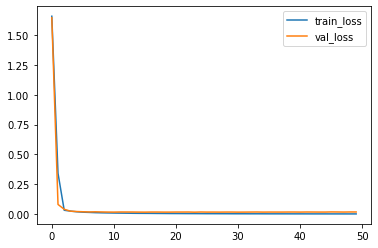

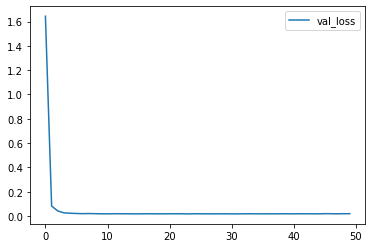

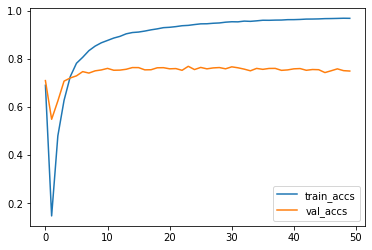

In [36]:
import matplotlib.pyplot as plt
import numpy as np
train_losses =[loss.item() for loss in train_losses]

plt.plot(train_losses[:], label='train_loss')
plt.plot(val_losses[:], label='val_loss')
plt.legend()
plt.savefig('train_losses_tests')
plt.show()

plt.plot(val_losses[:], label='val_loss')
plt.legend()
plt.savefig('val_losses_test')
plt.show()

plt.plot(train_accs, label='train_accs')
plt.plot(val_accs, label='val_accs')
plt.legend()
plt.savefig('accuracies_test')
plt.show()

## Part 4. Evaluation and Analysis

In [37]:
from test import evaluate_test_set
load_model=True
if load_model:
    best_model = SiameseBiLSTMAttention(
        batch_size=batch_size,
        output_size=output_size,
        hidden_size=hidden_size,
        vocab_size=vocab_size,
        embedding_size=embedding_size,
        embedding_weights=embedding_weights,
        lstm_layers=lstm_layers,
        self_attention_config=self_attention_config,
        attention_encoder_config=attention_encoder_config,
        fc_hidden_size=fc_hidden_size,
        device=device,
        pad_index=pad_index,
        bidirectional=bidirectional,
        dropout=dropout
    )
    # move model to device
    best_model.to(device)
    best_model.load_state_dict(torch.load("siamese_lstm_attention.pth"))
    best_model.eval()


test_acc, r, rho,mse, least_1, least_2, most_1, most_2  = evaluate_test_set(
    model=best_model,
    data_loader=sick_dataloaders,
    config_dict={
        "device": device,
        "model_name": "siamese_lstm_attention",
        "self_attention_config": self_attention_config,
    },
)

print('final accuracy on test set is {}'.format(test_acc))
print('pearsons r test set is {}'.format(r))
print('spearman rho on test set is {}'.format(rho))
print('mean square error on test set is {}'.format(mse))

INFO:root:Evaluating accuracy on test set


Worst score is 0.5855222046375275 and should be 1.0
Best score is 4.999999403953552 and should be 4.900000095367432
tensor([  9,  26,  34,  21, 132,  29,  77, 180,   1,   1,   1,   1,   1,   1])
tensor([  9,  26,  34,  21, 132,  29,  77, 180,   1,   1,   1,   1,   1,   1])
final accuracy on test set is 0.5704495696383433
pearsons r test set is (0.7666806550871842, 0.0)
spearman rho on test set is SpearmanrResult(correlation=0.7053612721555964, pvalue=0.0)
mean square error on test set is 0.0175018310546875


### Some Analysis of model sentences

In [39]:

worst_sen_1 = [sick_data.vocab.itos[token] for token in least_1]
print(worst_sen_1)
worst_sen_2 = [sick_data.vocab.itos[token] for token in least_2]
print(worst_sen_2)

best_sen_1 = [sick_data.vocab.itos[token] for token in most_1]
print(best_sen_1)
best_sen_2 = [sick_data.vocab.itos[token] for token in most_2]
print(best_sen_2)



## Test on some manual sentences
test_sentences1 = [ 'the cat sits outside <pad> <pad>',
                    'a man is playing guitar <pad>',
                    'the new movie is awesome <pad>',
                    'the dog plays in the garden',
                    'i like ice skating <pad> <pad>']

test_sentences2 = [ 'the dog plays in the garden',
                    'a woman watches TV <pad> <pad>',
                    'the new movie is so great',
                    'the dog plays in the garden',
                    'this mountain is beautiful <pad> <pad>']

tokenized_sen1= list()             
for sentence in test_sentences1:
    tokenized = [sick_data.vocab.stoi[word] for word in sentence.split()]
    tokenized_sen1.append(tokenized)
tokenized_sen1 = torch.tensor(tokenized_sen1).to(device)

tokenized_sen2= list()             
for sentence in test_sentences2:
    tokenized = [sick_data.vocab.stoi[word] for word in sentence.split()]
    tokenized_sen2.append(tokenized)
tokenized_sen2=torch.tensor(tokenized_sen2).to(device)


predic, a1, a2 = best_model(tokenized_sen1, tokenized_sen2)

for i in range(len(test_sentences1)):
    print('similarity: {:.2f} for sentences  {} - {}'.format(predic[i]*5.0, test_sentences1[i], test_sentences2[i]))

['jet', 'flying', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['no', 'dog', 'barking', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['girl', 'blue', 'shirt', 'walking', 'sidewalk', 'holding', 'pink', 'sign', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['girl', 'blue', 'shirt', 'walking', 'sidewalk', 'holding', 'pink', 'sign', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
similarity: 2.18 for sentences  the cat sits outside <pad> <pad> - the dog plays in the garden
similarity: 1.92 for sentences  a man is playing guitar <pad> - a woman watches TV <pad> <pad>
similarity: 4.98 for sentences  the new movie is awesome <pad> - the new movie is so great
similarity: 5.00 for sentences  the dog plays in the garden - the dog plays in the garden
similarity: 3.68 for sentences  i like ice skating <pad> <pad> - this mountain is beautiful <pad> <pad>


In [40]:
import matplotlib


def colorize(words, color_array):
    '''
    colorizes the self attention block vectors over input words
    '''
    cmap=matplotlib.cm.Reds
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

In [41]:

## Colorize the sample sentences for visulization
with open('colorize.html', 'a') as f:
    for i in range(len(test_sentences1)):
        words_sen1 = test_sentences1[i].split()
        words_sen2 = test_sentences2[i].split()
        sen_attention_matrix1 = a1[i]
        sen_attention_matrix2 = a2[i]
        for (vec1, vec2) in zip(sen_attention_matrix1, sen_attention_matrix2):
            c1=colorize(words_sen1, vec1.cpu().detach().numpy())
            c2=colorize(words_sen2, vec2.cpu().detach().numpy())
            f.write(c1)
            f.write('&nbsp;')
            f.write(c2)
            f.write('<br>')
        f.write('<br>')


torch.Size([5, 1, 6])
